# MIR calculator
The other day I was talking with a friend that studies Medicine in Spain. After they finish their degree, all students must take the MIR [exam](https://www.wikiwand.com/es/Examen_MIR) that will rank them. The higher you are in that ranking, the better chances you have at selecting the speciality you like from a limited pool of job postings acrross diferent hospitals in the country.

The "MIR" is a test exam with 225 questions, each with 4 options. If you get the answer right, you gain 3 points. If you select the wrong answer, you get deducted 1 point.

We were discussing if it is optimal to answer a question even if you don't know the answer. Or is it better to not answer it, just in case you get deducted points?


She told me she noticed how her mark improved when she started to answer randomly the questions for which she really had no clue what the answer was. I was curious if this was just luck, or if it actually makes sense to answer the unknown questions.


This notebook explores to what extent this strategy is optimal, and quantitatively assesses what is the gain in mark you should expect by following the _answer-everything_ strategy.

In [1]:
import seaborn as sns; sns.set_style("whitegrid")
import random
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
class MIR(object):
    '''Class for the MIR exam.
    Parameters
    ----------
    study_level: int
        The level of preparation you have. Must be an integer between
        0 (you answer randomly everything) and 10 (you know all the
        correct answers).
    n_questions: int
        The number of questions that the exam hast. The MIR has 225
        questions, but this could change in principle.
    answer_unknowns: bool
        Whether we will randomly answer the questions we don't know
        or we will decide to not answer them.
    '''
    def __init__(self, study_level, n_questions, answer_unknowns):
        self.study_level = study_level
        self.n_questions = n_questions
        self.answer_unknowns = answer_unknowns

    def solveExam(self):
        '''Answer every question in the exam. Return the mark out of 10'''
        score = 0
        for question in range(0, self.n_questions):
            score = self._answerQuestion(score)
        return((score / (3 * self.n_questions)) * 10)

    def _answerQuestion(self, score):
        '''Answer a question. A higher study_level gives a higher chance
        of getting it right. If we dont know the answer, randomly guess
        if answer_unknowns is True. Returns the updated score'''
        chance = random.randint(1, 10)
        if chance <= self.study_level:
            score += 3
        elif self.answer_unknowns:
            result = random.choice(['a', 'b', 'c', 'd'])
            answer = random.choice(['a', 'b', 'c', 'd'])
            if result == answer:
                score += 3
            else:
                score -= 1
        return(score)

    def _getScoreProgress(self):
        '''Answer all questions in a single exam and returns the score
        progress as a list.'''
        score_Progress = []
        score = 0
        for question in range(0, self.n_questions):
            score = self._answerQuestion(score)
            score_Progress.append((score / (3 * self.n_questions)) * 10)
        return(score_Progress)

What happens if we take the exam 10000 times randomly, without having studied at all?

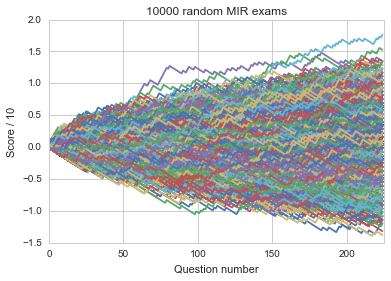

In [3]:
itera = 0
mir = MIR(study_level = 0, n_questions=225, answer_unknowns=True)
max_iter = 10000
while itera < max_iter:
    itera += 1
    plt.plot(mir._getScoreProgress())
plt.ylabel("Score / 10")
plt.xlabel("Question number")
plt.title("{} random MIR exams".format(max_iter))
plt.xlim(0, 225)
plt.show()

There's chances that you can luck out and get close to a 1.5/10 even if you haven't studied at all! Notice, however, that if you are _unlucky_, you might score a -1.5/10. Ouch!

But it looks like a normal distribution centered around 0 to me. Is it actually gaining you anything _on average_?

Let's take a look at the distribution of marks for the two types of strategy, at the same study level.

In [4]:
def solve_ManyExams(study_level, max_iter=1000):
    '''
    Returns two lists:
        distrib1: The marks answering randomly unknown questions
        distrib2: The marks answering only the questions you know.'''
    iteration = 0
    distrib1 = []
    distrib2 = []
    while iteration < max_iter:
        mir1 = MIR(
            study_level=study_level, n_questions=225, answer_unknowns=True)
        mir2 = MIR(
            study_level=study_level, n_questions=225, answer_unknowns=False)
        distrib1.append(mir1.solveExam())
        distrib2.append(mir2.solveExam())
        iteration += 1
    return(distrib1, distrib2)

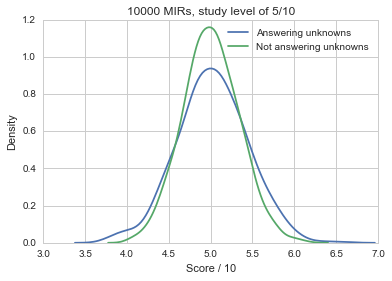

In [5]:
distrib1, distrib2 = solve_ManyExams(study_level=5)
sns.distplot(distrib1, hist=False, label='Answering unknowns')
sns.distplot(distrib2, hist=False, label='Not answering unknowns')
plt.xlabel("Score / 10")
plt.ylabel("Density")
plt.title("10000 MIRs, study level of 5/10")
plt.legend()
plt.show()

In [6]:
print("Answering unknowns:\t%.2f+-%.2f\n" % (np.mean(distrib1), np.std(distrib1)))
print("Not Answering unknowns:\t%.2f+-%.2f" % (np.mean(distrib2), np.std(distrib2)))

Answering unknowns:	5.02+-0.43

Not Answering unknowns:	5.00+-0.34


Answering the questions you don't know doesn't affect your mean score. It just increases the variability, making it possible to get slightly higher (and lower) marks.

Let's explore if this is affected by the study level.

In [7]:
mean_list = []
std_list = []
for study_level in range(0,11):
    distrib1, distrib2 = solve_ManyExams(study_level, max_iter=50000) # Lots of iterations to get clean distributions
    mean_diff = np.mean(distrib1) - np.mean(distrib2)
    std_diff = np.std(distrib1) - np.std(distrib2)
    mean_list.append(mean_diff)
    std_list.append(std_diff)

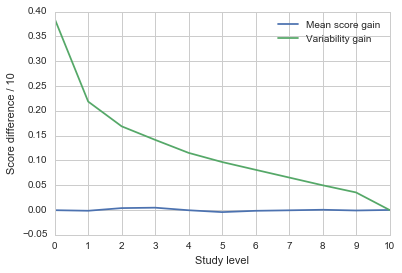

In [8]:
plt.plot(list(range(0,11)),mean_list, label="Mean score gain")
plt.plot(list(range(0,11)),std_list, label="Variability gain")
plt.xlabel("Study level")
plt.ylabel("Score difference / 10")
plt.xticks([x for x in range(0, 11)])
plt.legend()
plt.show()

Your average mark will not be affected by this strategy, no matter how much you've prepared for the exam. However, the more questions you do know, the less your variability will be increased by answering unknown questions (which is logical, because the more you'll have studied, the less frequently you'll have to face the decision).

## Conclusion
The _answer everything_ mentality isn't really gaining you anything on average. It just makes your mark to be more variable, which in my opinion is something that you actually want to avoid. 

Of course, this is taking into account that you actually _don't have any preference for any of the 4 possibilities_ of the question you don't know. **Note:** This is actually almost never true, as you might almost always have a slight preference for any of the possibilities. As soon as your belief in any of the answers is higher than 25%, it will be worth to take the risk, in the long run.

**Take home message:** study as hard as you can for the exam, and don't worry too much about this strategy! In my opinion:

   - **Don't** chose randomly between the 4 possibilities if you really have no clue. 225 questions are too few, and variability can screw you up. Again, this will almost never be the case.
   - **Do** answer randomly if you're only doubting between 3 or 2 possibilities, or if you have the slightest preference for any of the 4 possibilities.